In [1]:
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import IPython

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

In [3]:
import scipy.io.wavfile
(rate, data) = scipy.io.wavfile.read('vivaldi.wav')
data = data[30000:200000,0]

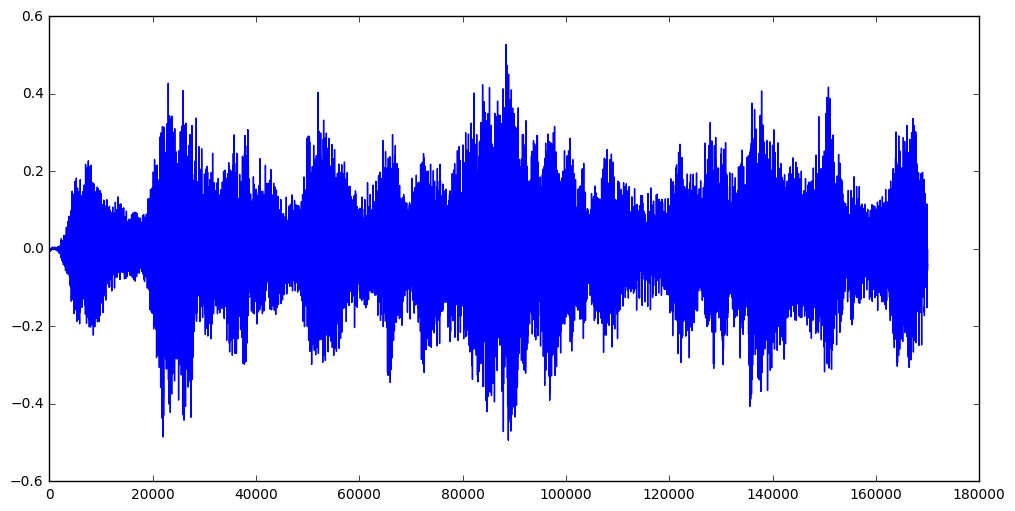

In [4]:
plt.plot(data)

In [5]:
IPython.display.Audio(data, rate=rate)

In [47]:
def stft(signal, window_size, hop_size):
    #window = np.hanning(window_size + 2)[1:-1]
    window = np.hanning(window_size)
    window /= sum(window)
    to_pad = hop_size - (len(signal) - window_size) % hop_size
    
    if to_pad < hop_size:
        signal = np.lib.pad(signal, (0, to_pad), 'constant', constant_values=0)
    
    return np.array([np.fft.fft(signal[i:i+window_size] * window)
                       for i in range(0, len(signal) - window_size, hop_size)])

In [48]:
def istft(data, window_size, hop_size):
    #window = np.hanning(window_size + 2)[1:-1]
    window = np.hanning(window_size)
    window /= sum(window)
    res = np.zeros(window_size + hop_size * data.shape[0])
    
    w_sum = np.zeros(len(res))
    for i in range(data.shape[0]):
        inverted = np.fft.ifft(data[i]).real
        res[i * hop_size : i * hop_size + window_size] += inverted * window
        w_sum[i * hop_size : i * hop_size + window_size] += window ** 2
        
    non_zero = w_sum != 0
    res[non_zero] /= w_sum[non_zero]
    
    return res

In [49]:
def spectrogram(signal, window_size, hop_size):
    return np.abs(stft(signal, window_size, hop_size)) ** 2

In [50]:
from IPython import display
import time

def ispectrogram(data, window_size, hop_size, iters=10):
    res = np.random.random(window_size + hop_size * data.shape[0])
#     res = np.zeros(window_size + hop_size * data.shape[0])
    init_magnitudes = np.sqrt(data)
    
    for i in range(iters):
#         plt.cla()
#         plt.plot(res)
#         display.clear_output(wait=True)
#         display.display(plt.gcf())
#         time.sleep(1.0)
        new_stft = stft(res, window_size, hop_size)
        non_zero = new_stft != 0
        new_stft[non_zero] = new_stft[non_zero] / np.abs(new_stft[non_zero])
        
        normalized_stft = init_magnitudes * new_stft
        res = istft(normalized_stft, window_size, hop_size)
        
    return res

In [51]:
f0 = 440
f1 = 880
fs = rate
T = 5

t = np.linspace(0, T, T*fs, endpoint=False)
sine = np.hstack([np.sin(2*np.pi*f0*t), np.sin(2*np.pi*f1*t)])

IPython.display.Audio(sine, rate=rate)

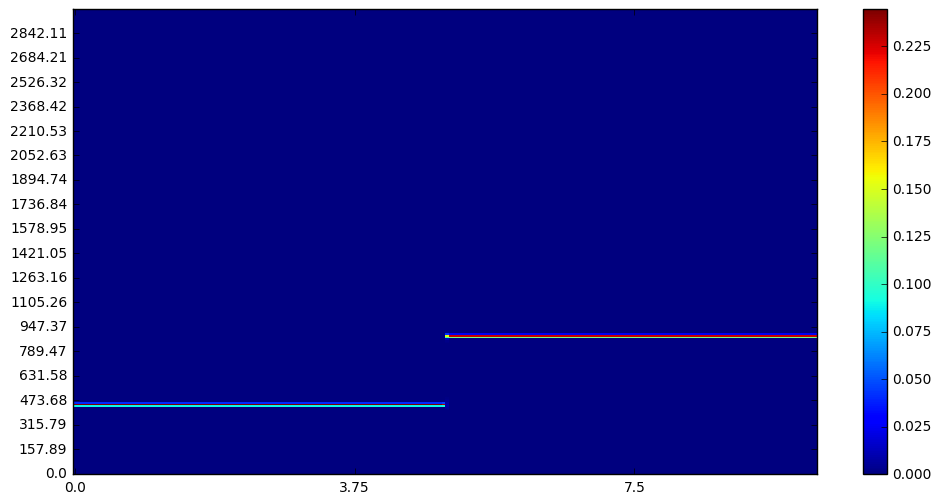

In [52]:
x = sine

window_size = 4096
hop_size = 2048
sample_rate = rate

min_freq = 0
min_freq_index = int(min_freq * window_size / sample_rate)
max_freq = 3000
max_freq_index = int(max_freq * window_size / sample_rate)
y_tick_count = 20

plt.yticks(np.linspace(0, max_freq_index - min_freq_index, y_tick_count), 
           np.round(np.linspace(min_freq, max_freq, y_tick_count), 2))

min_time = 0
min_time_index = int(min_time * sample_rate) / hop_size
max_time = 15
max_time_index = int(max_time * sample_rate) / hop_size
x_tick_count = 5

plt.xticks(np.linspace(0, max_time_index - min_time_index, x_tick_count), 
           np.round(np.linspace(min_time, max_time, x_tick_count), 2))

spec = spectrogram(x, window_size, hop_size)

plt.imshow(spec.T[min_freq_index:max_freq_index, min_time_index:max_time_index], 
           origin='lower', aspect='auto', interpolation='nearest')
plt.colorbar()

In [53]:
griflim_inv = ispectrogram(spec, window_size, hop_size, iters=10)
IPython.display.Audio(np.clip(griflim_inv[:len(sine)], -1, 1), rate=rate)

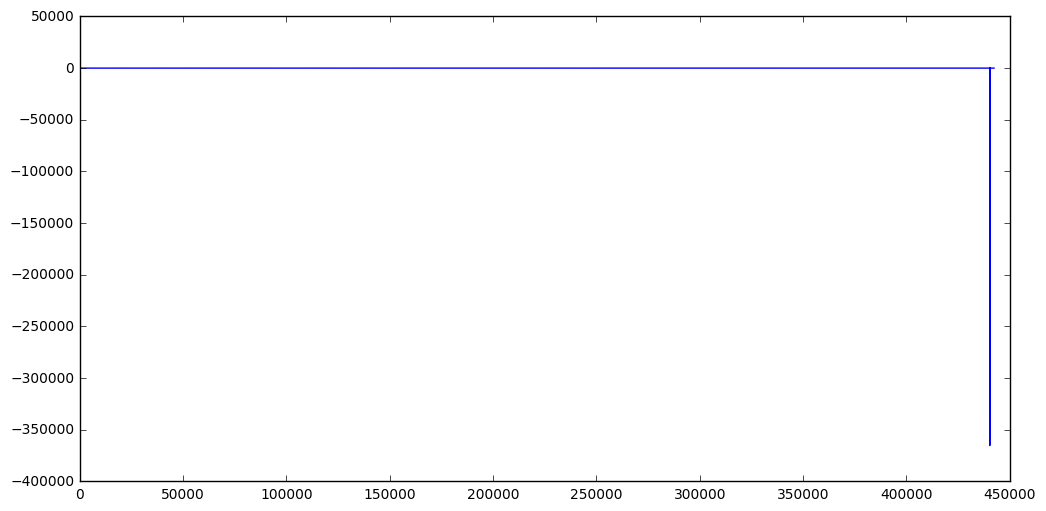

In [54]:
plt.plot(griflim_inv)

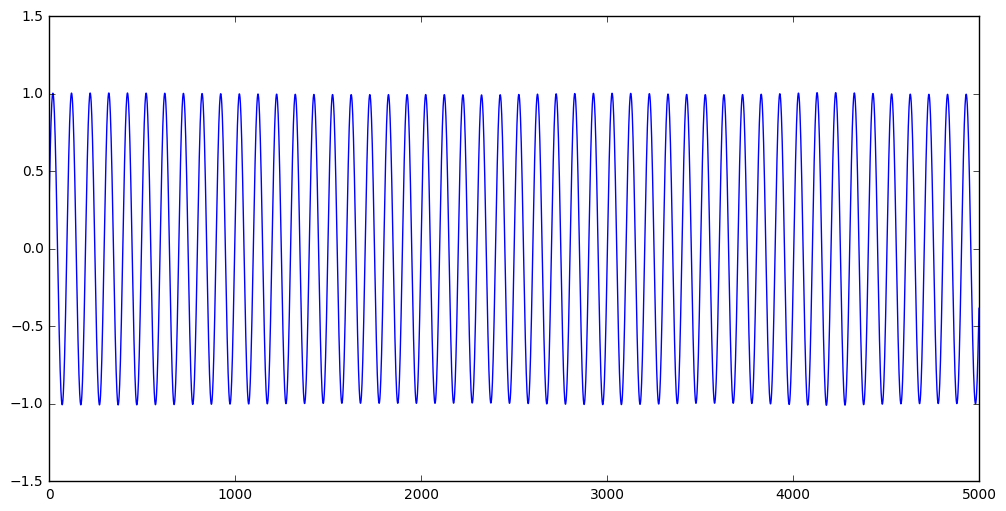

In [42]:
plt.plot(np.clip(griflim_inv[5000:10000], -10, 10))